In [45]:
import data, model, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch.utils.tensorboard as tb
import torchvision

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
tb_writer = tb.SummaryWriter('log')

In [61]:
VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 64
CHANNELS = 3
STYLE_DIM = 512
CONTENT_DIM = 1024
BATCH_SIZE = 1
#CONTENT_LOSS_WEIGHTS = {'input' : 0.0, 'relu3' : 0.0, 'relu4' : 1e2, 'relu5' : 0.0}
#STYLE_LOSS_WEIGHTS = {'input' : 0.0, 'relu1' : 1e2, 'relu2' : 1e2, 'relu3' : 1e2, 'relu4' : 1e2, 'relu5' : 1e2}

CONTENT_LOSS_WEIGHTS = {
    'relu_1_1' : 4e-2,
    'relu_4_2' : 4e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}

In [62]:
def forward(content, style, content_encoder, style_encoder, decoder):
    """ Forwards a batch through the pipeline.
    
    Parameters:
    -----------
    content : torch.Tensor, shape [B, C, H, W]
        The content image.
    style : torch.Tensor, shape [B, C, H', W']
        The style image, usually H' = H and W' = W.
    content_encoder : torch.nn.modules.Module
        Encoder for content images.
    style_encoder : torch.nn.modules.Module
        Encoder for style images.
    decoder : torch.nn.modules.Module
        Decoder that uses AdaIn to decode the content and apply the style.

    Returns:
    --------
    reco : torch.Tensor, shape [B, C, H, W]
        A reconstruction of the content after application of the style.
    content_representation : torch.Tensor, shape [B, D]
        Content representation.
    style_representation : torch.Tensor, shape [B, D']
        The latent style representation.
    """
    content_representation = content_encoder(content)
    style_representation = style_encoder(style)
    #transformed_content = function.adain(content_representation, style_representation)
    #print(content_representation.shape)
    #print(style_representation.shape)
    reco = decoder(content_representation, style_representation)
    #reco = decoder(content_representation)
    return reco, content_representation, style_representation

def print_content_feature_contrib(feature_activations_x, feature_activations_y):
    for key in feature_activations_x:
        feature_loss = torch.nn.functional.mse_loss(feature_activations_x[key], feature_activations_y[key])
        weight = 0.0
        if key in CONTENT_LOSS_WEIGHTS:
            weight = CONTENT_LOSS_WEIGHTS[key]
        weighted_loss = weight * feature_loss
        print("Content layer {} loss: {} weight: {} weighted loss: {}".format(key, feature_loss, weight, weighted_loss))

def print_style_feature_contrib(features_style, features_transformed):
    for key, weight in STYLE_LOSS_WEIGHTS.items():
        Gx = function.gram_matrix(features_style[key])
        Gy = function.gram_matrix(features_transformed[key])
        value = torch.nn.functional.mse_loss(Gx, Gy)
        weighted_value = weight * value
        print(f'Style loss {key} with weight {weight}: {value} weighted loss: {weighted_value}')

In [63]:
data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

TRAINING_PORTION=1
data_content = data.load_debug_dataset('../dataset/content', resolution=RESOLUTION)
data_content, _ = torch.utils.data.random_split(data_content, [TRAINING_PORTION, len(data_content) - TRAINING_PORTION])
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
#data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
#data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

In [68]:
#content_encoder = model.ResNetEncoder(CONTENT_DIM, architecture=torchvision.models.resnet34)
#style_encoder = model.ResNetEncoder(STYLE_DIM, architecture=torchvision.models.resnet18)
#decoder = model.Decoder(CONTENT_DIM, STYLE_DIM, (RESOLUTION, RESOLUTION))

# FLATTEN
#content_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION), flattened_output_dim=CONTENT_DIM)
#style_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION), flattened_output_dim=STYLE_DIM)
#decoder = model.VGGDecoder((CHANNELS, RESOLUTION, RESOLUTION), STYLE_DIM, CONTENT_DIM)

# NO FLATTEN
#content_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION))
#style_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION))
#decoder = model.VGGDecoder((CHANNELS, RESOLUTION, RESOLUTION), STYLE_DIM, None)

# ADAIN DECODER, content NO FLATTEN, style FLATTEN
content_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION))
style_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION), flattened_output_dim=STYLE_DIM)
decoder = model.VGGDecoder((CHANNELS, RESOLUTION, RESOLUTION), STYLE_DIM, None)

loss_net = loss.LossNet()
_ = loss_net.eval()

In [69]:
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in content_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in decoder.parameters():
    trainable_parameters.append(parameter)

In [70]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-5)

# Overfitting
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    content_image, style_image = content_image[:1], style_image[:1]
    break
content_encoder.train()
style_encoder.train()
decoder.train()
if torch.cuda.is_available():
    content_image = content_image.to('cuda')
    style_image = style_image.to('cuda')
for iteration in range(ITERATIONS):
    optimizer.zero_grad()
    
    stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
    total_loss = perceptual_loss + style_loss
    total_loss.backward()
    optimizer.step()

    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        tb_writer.add_images('images', torch.from_numpy(np.concatenate([
            data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        ])), iteration)

    0 / 15002: loss : 3.7348 -- perceptual loss : 1.1135 -- style loss : 2.6212
Validation...


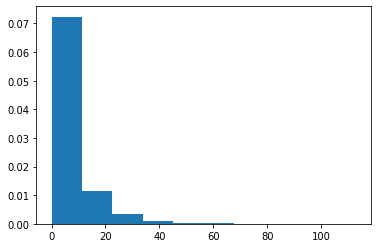

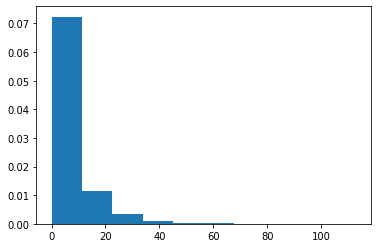

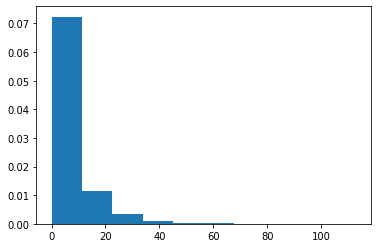

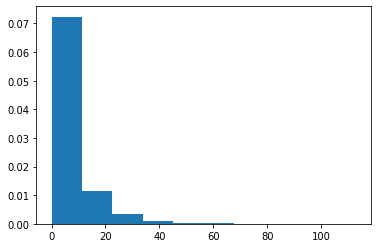

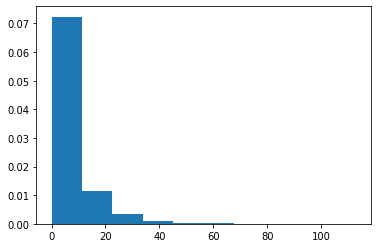

    5 / 5: loss : 11.0333 -- perceptual loss : 1.5405 -- style loss : 9.4928
Training...
  100 / 15002: loss : 0.5208 -- perceptual loss : 0.2918 -- style loss : 0.22908
Validation...


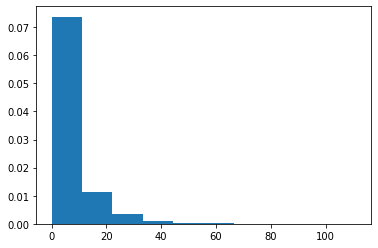

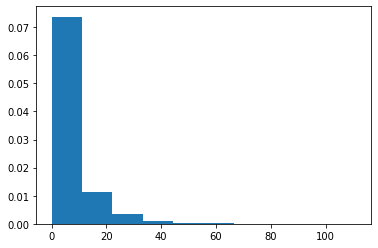

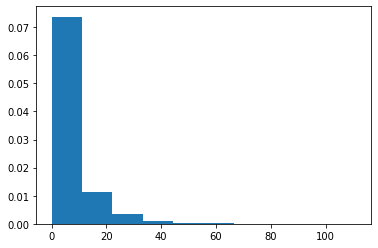

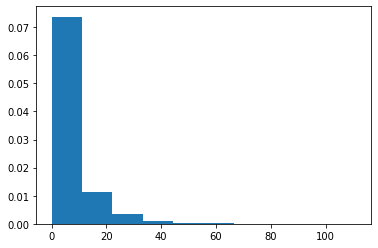

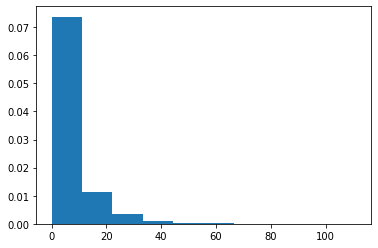

    5 / 5: loss : 0.5190 -- perceptual loss : 0.2908 -- style loss : 0.2282
Training...
  200 / 15002: loss : 0.4296 -- perceptual loss : 0.2140 -- style loss : 0.2156
Validation...


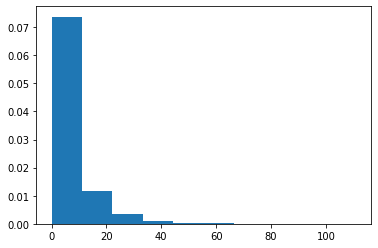

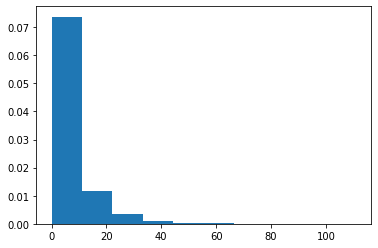

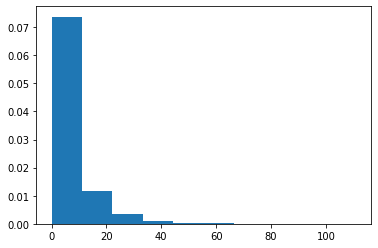

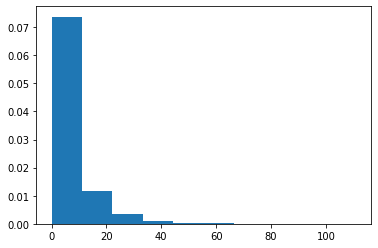

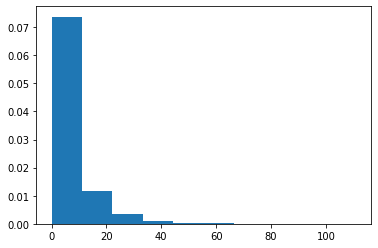

    5 / 5: loss : 0.4292 -- perceptual loss : 0.2137 -- style loss : 0.2155
Training...
  300 / 15002: loss : 0.4024 -- perceptual loss : 0.1897 -- style loss : 0.2127
Validation...


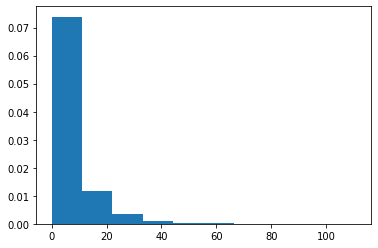

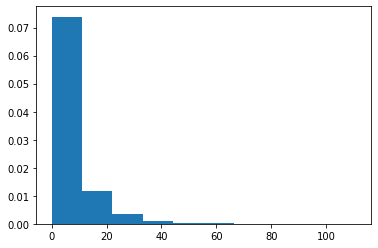

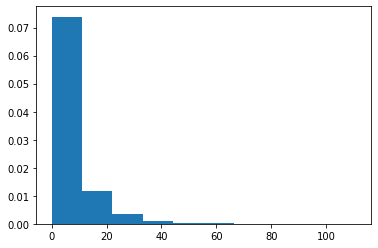

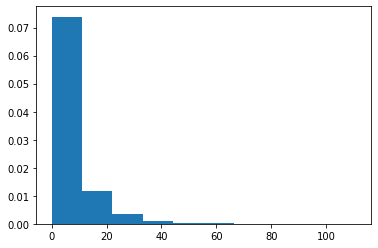

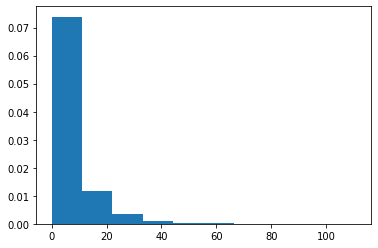

    5 / 5: loss : 0.4022 -- perceptual loss : 0.1900 -- style loss : 0.2122
Training...
  400 / 15002: loss : 0.3897 -- perceptual loss : 0.1775 -- style loss : 0.2122
Validation...


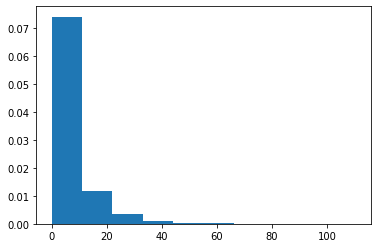

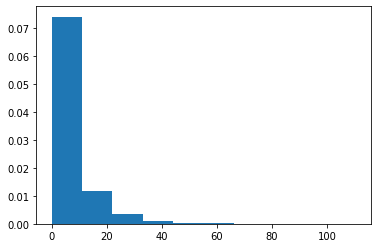

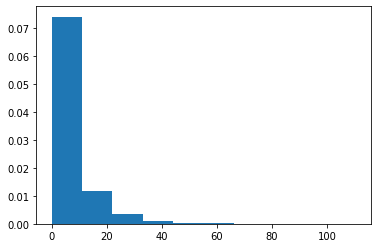

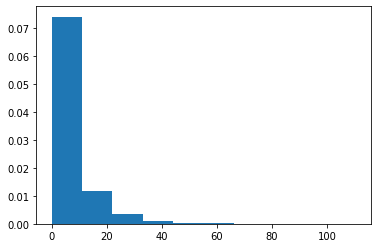

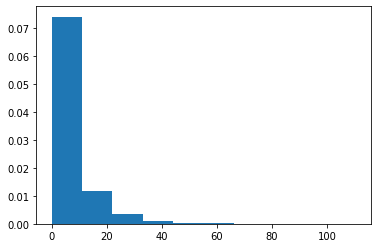

    5 / 5: loss : 0.3893 -- perceptual loss : 0.1797 -- style loss : 0.2096
Training...
  500 / 15002: loss : 0.3811 -- perceptual loss : 0.1738 -- style loss : 0.2073
Validation...


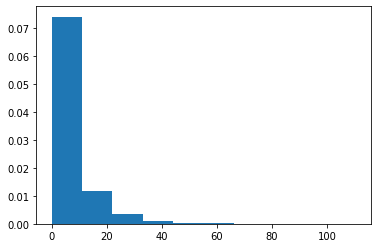

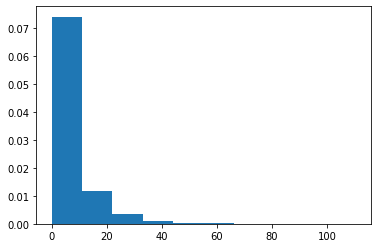

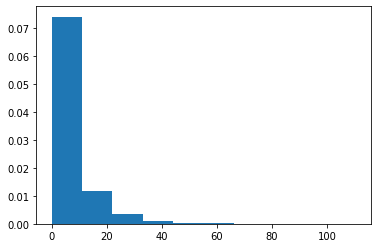

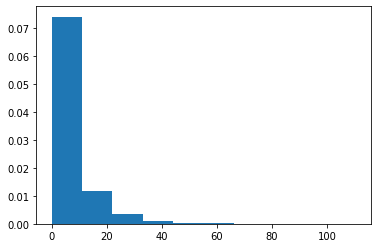

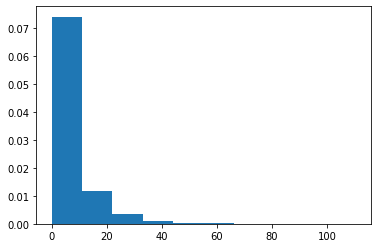

    5 / 5: loss : 0.3809 -- perceptual loss : 0.1720 -- style loss : 0.2089
Training...
  600 / 15002: loss : 0.3751 -- perceptual loss : 0.1678 -- style loss : 0.2074
Validation...


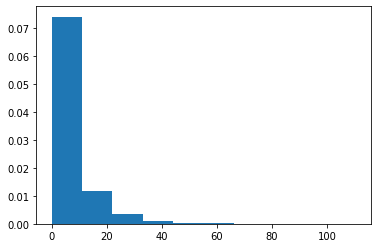

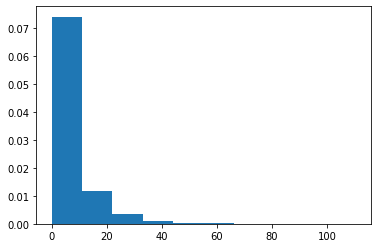

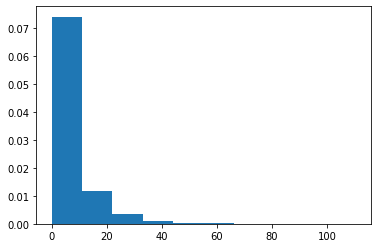

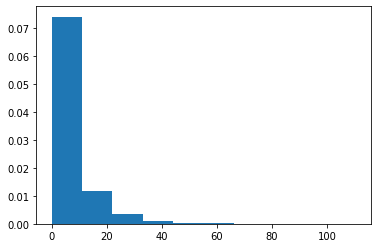

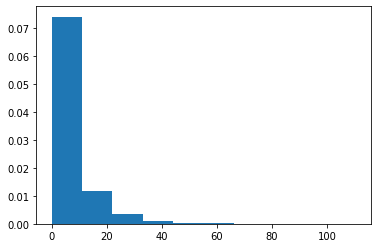

    5 / 5: loss : 0.3751 -- perceptual loss : 0.1675 -- style loss : 0.2077
Training...
  700 / 15002: loss : 0.3709 -- perceptual loss : 0.1627 -- style loss : 0.2082
Validation...


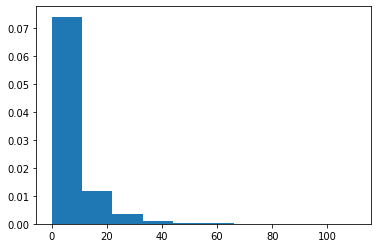

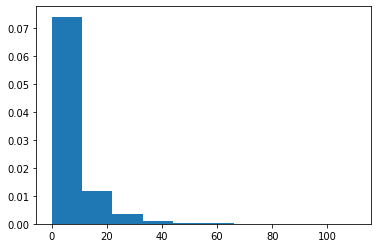

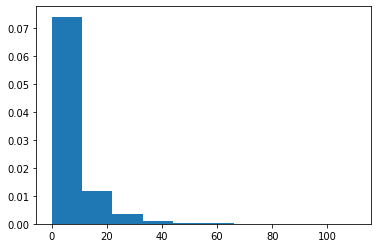

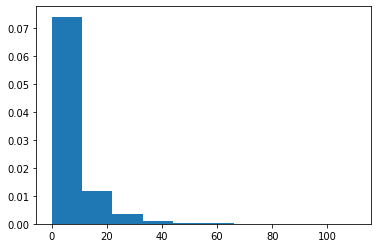

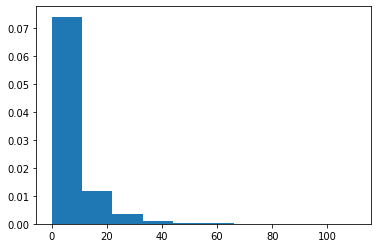

    5 / 5: loss : 0.3714 -- perceptual loss : 0.1649 -- style loss : 0.2065
Training...
  800 / 15002: loss : 0.3695 -- perceptual loss : 0.1632 -- style loss : 0.2063
Validation...


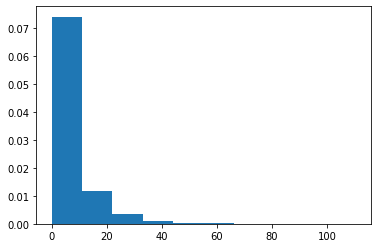

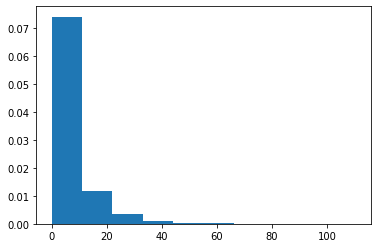

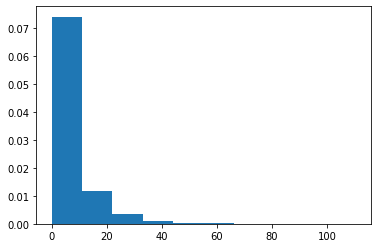

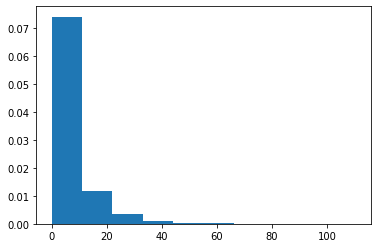

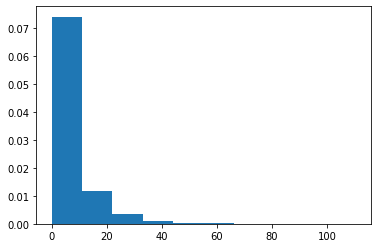

    5 / 5: loss : 0.3694 -- perceptual loss : 0.1618 -- style loss : 0.2076
Training...
  900 / 15002: loss : 0.3655 -- perceptual loss : 0.1602 -- style loss : 0.2052
Validation...


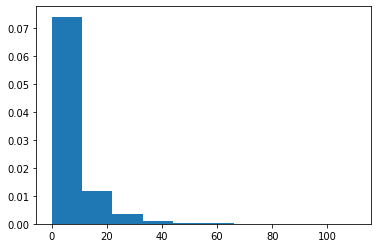

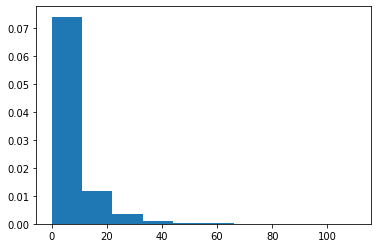

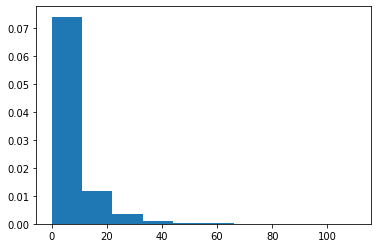

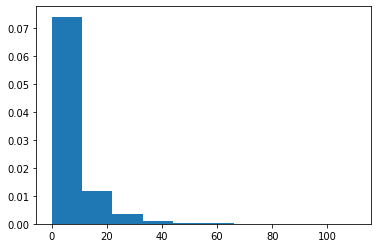

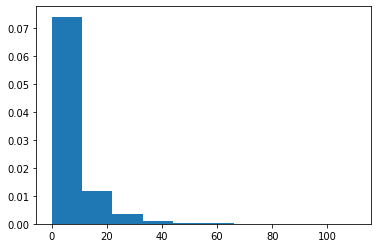

    5 / 5: loss : 0.3656 -- perceptual loss : 0.1616 -- style loss : 0.2040
Training...
 1000 / 15002: loss : 0.3643 -- perceptual loss : 0.1564 -- style loss : 0.2079
Validation...


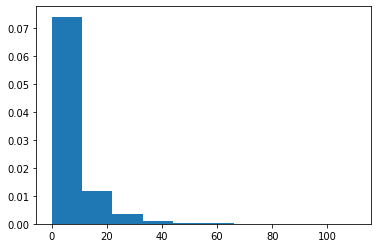

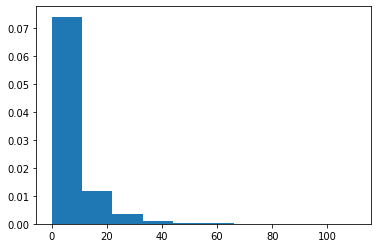

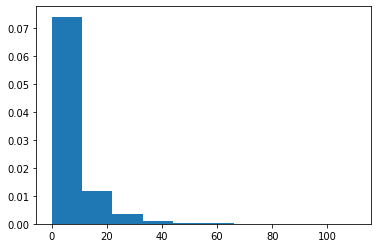

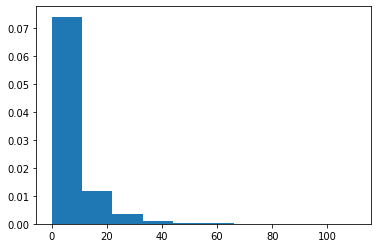

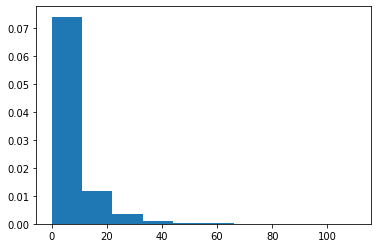

    5 / 5: loss : 0.3642 -- perceptual loss : 0.1629 -- style loss : 0.2013
Training...
 1100 / 15002: loss : 0.3636 -- perceptual loss : 0.1606 -- style loss : 0.2030
Validation...


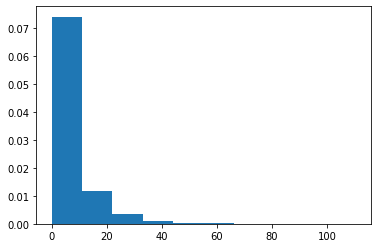

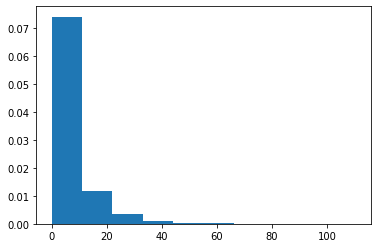

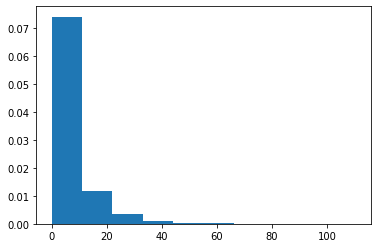

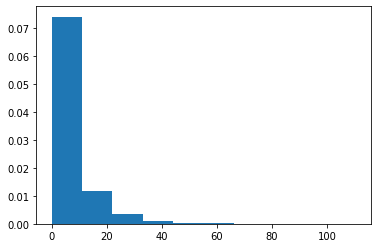

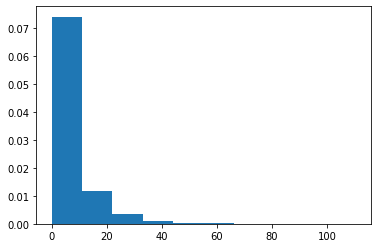

    5 / 5: loss : 0.3635 -- perceptual loss : 0.1582 -- style loss : 0.2053
Training...
 1200 / 15002: loss : 0.3616 -- perceptual loss : 0.1604 -- style loss : 0.2012
Validation...


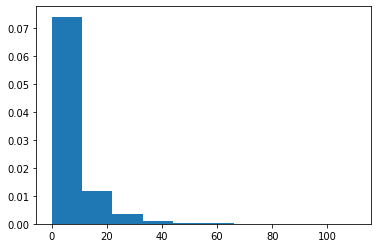

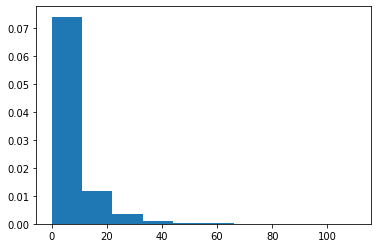

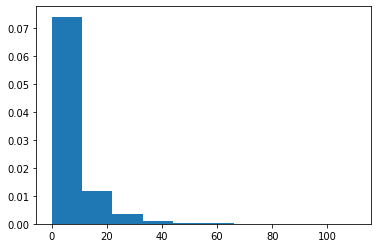

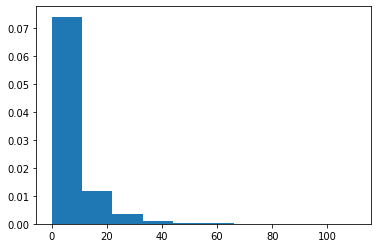

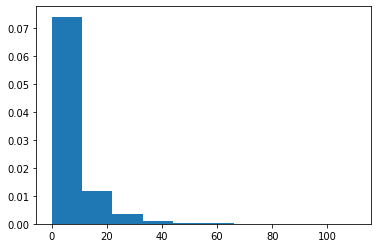

    5 / 5: loss : 0.3617 -- perceptual loss : 0.1587 -- style loss : 0.2030
Training...
 1300 / 15002: loss : 0.3607 -- perceptual loss : 0.1567 -- style loss : 0.2040
Validation...


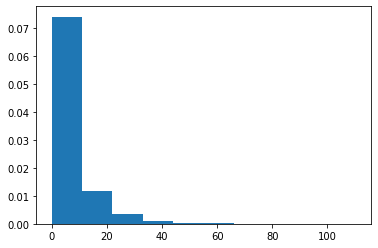

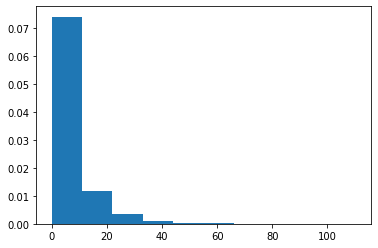

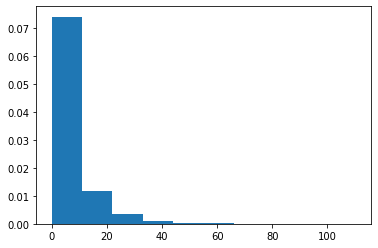

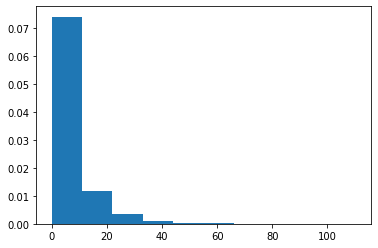

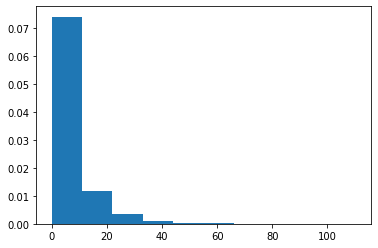

    5 / 5: loss : 0.3606 -- perceptual loss : 0.1582 -- style loss : 0.2024
Training...
 1400 / 15002: loss : 0.3612 -- perceptual loss : 0.1575 -- style loss : 0.2036
Validation...


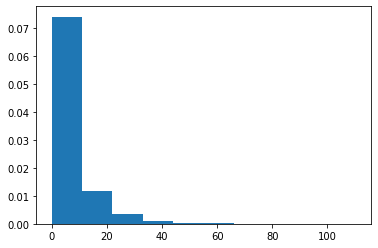

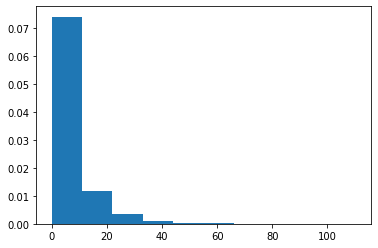

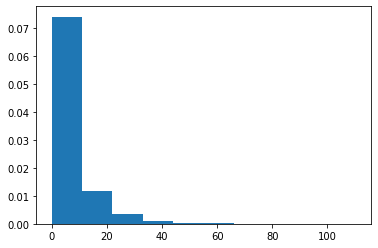

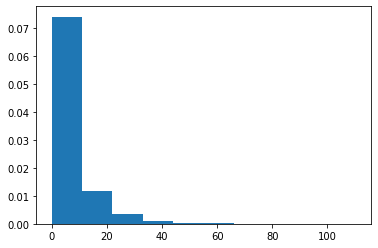

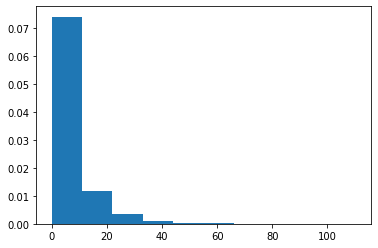

    5 / 5: loss : 0.3610 -- perceptual loss : 0.1592 -- style loss : 0.2018
Training...
 1500 / 15002: loss : 0.3609 -- perceptual loss : 0.1583 -- style loss : 0.2025
Validation...


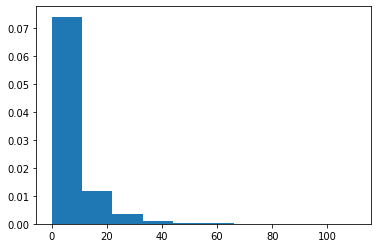

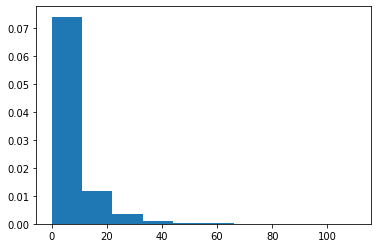

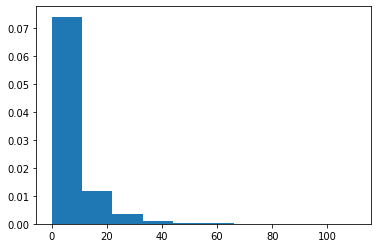

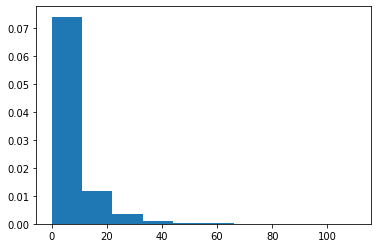

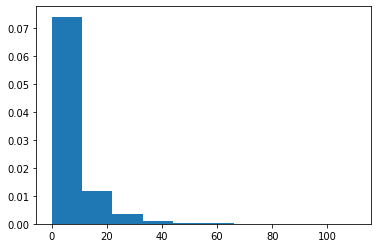

    5 / 5: loss : 0.3603 -- perceptual loss : 0.1559 -- style loss : 0.2044
Training...
 1600 / 15002: loss : 0.3614 -- perceptual loss : 0.1567 -- style loss : 0.2047
Validation...


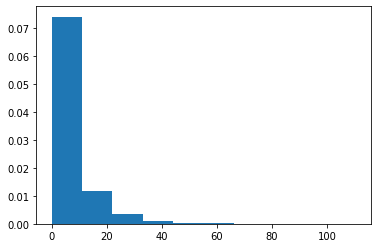

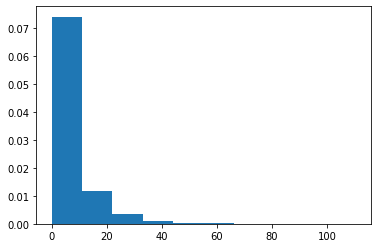

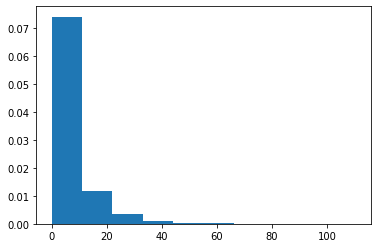

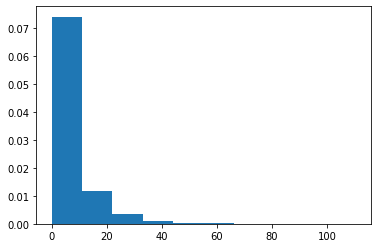

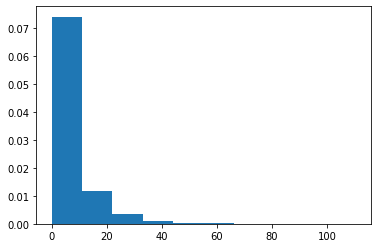

    5 / 5: loss : 0.3613 -- perceptual loss : 0.1607 -- style loss : 0.2005
Training...
 1700 / 15002: loss : 0.3624 -- perceptual loss : 0.1638 -- style loss : 0.1986
Validation...


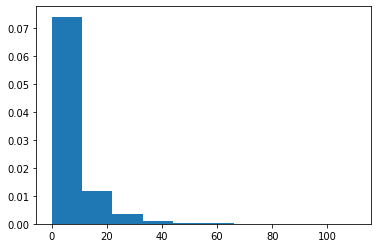

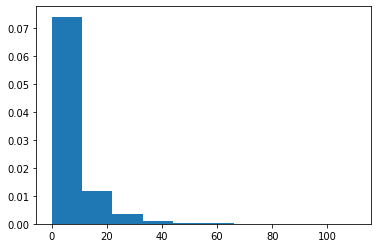

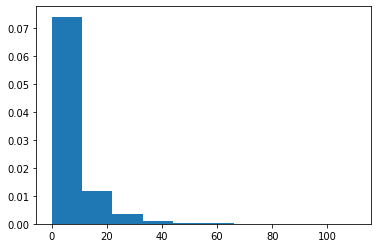

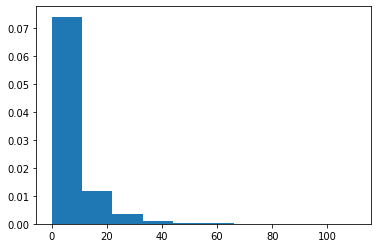

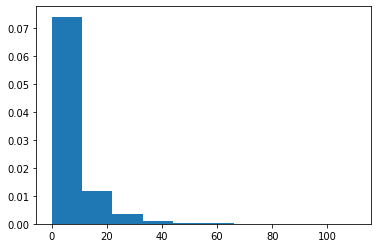

    5 / 5: loss : 0.3615 -- perceptual loss : 0.1561 -- style loss : 0.2053
Training...
 1800 / 15002: loss : 0.3567 -- perceptual loss : 0.1552 -- style loss : 0.2016
Validation...


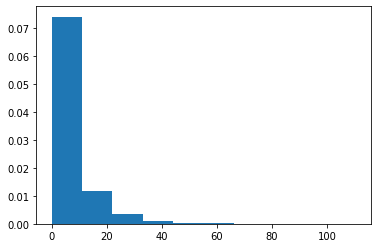

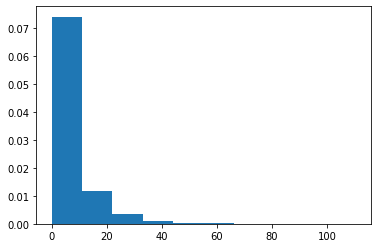

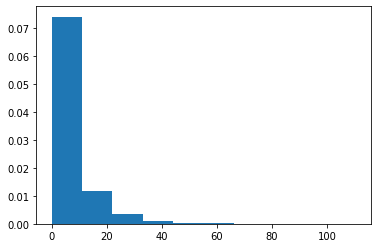

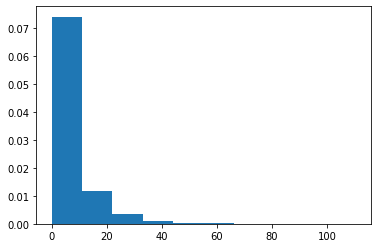

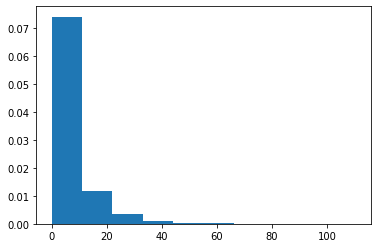

    5 / 5: loss : 0.3564 -- perceptual loss : 0.1554 -- style loss : 0.2009
Training...
 1900 / 15002: loss : 0.3567 -- perceptual loss : 0.1532 -- style loss : 0.2035
Validation...


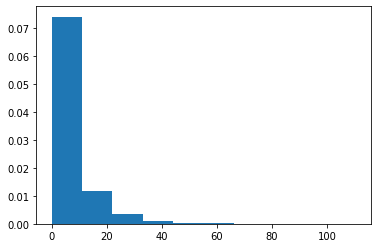

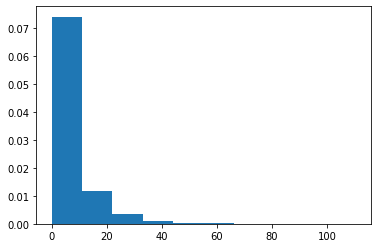

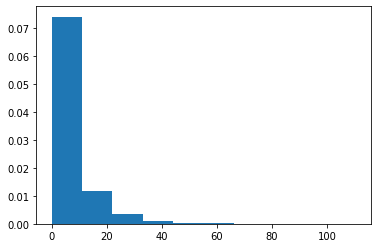

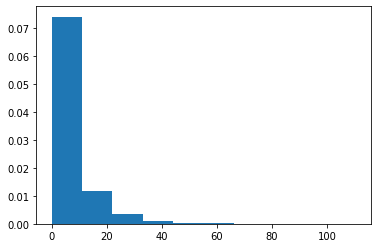

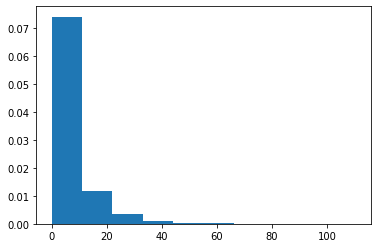

    5 / 5: loss : 0.3569 -- perceptual loss : 0.1558 -- style loss : 0.2011
Training...
 2000 / 15002: loss : 0.3568 -- perceptual loss : 0.1544 -- style loss : 0.2024
Validation...


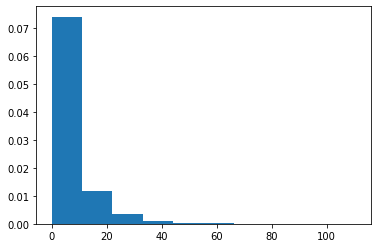

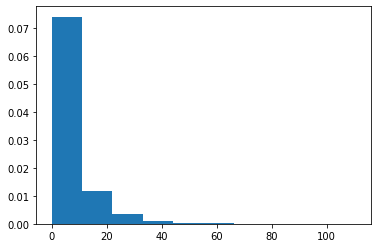

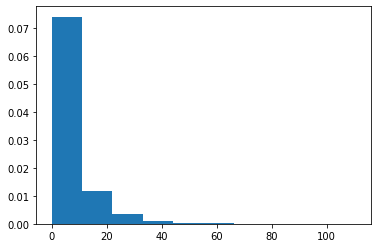

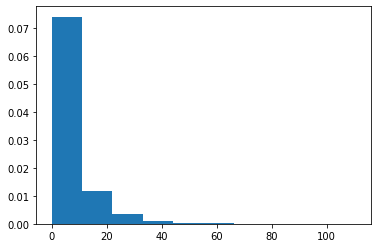

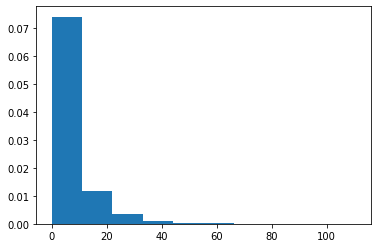

    5 / 5: loss : 0.3575 -- perceptual loss : 0.1571 -- style loss : 0.2004
Training...


KeyboardInterrupt: 

In [71]:
iteration = 0
val_step = 0
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: 
        break
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')
    
    content_encoder.train(), style_encoder.train(), decoder.train()
    optimizer.zero_grad()
    
    stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
    total_loss = perceptual_loss + style_loss
    total_loss.backward()
    optimizer.step()
    
    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        #tb_writer.add_images('train images', torch.from_numpy(np.concatenate([
        #    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        #])), iteration)
        # Validate
        print('\nValidation...')
        with torch.no_grad():
            val_iteration = 0
            content_encoder.eval(), style_encoder.eval(), decoder.eval()
            for (content_image, content_path), (style_image, style_path) in data_loader_train:
                if val_iteration >= VAL_ITERATIONS:
                    print('\nTraining...')
                    break
                    
                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')
                stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
                
                torch.set_printoptions(profile="full")
                #print(content_encoding)
                torch.set_printoptions(profile="default")
    
                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_stylized = loss_net(stylized)

                perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
                style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
                total_loss = perceptual_loss + style_loss
                
                #plt.hist(content_encoding.detach().cpu().numpy().reshape(-1), bins=np.arange(-10, 10.05, 0.05), range=[-10.0, 10.0], density=True)
                plt.hist(content_encoding.detach().cpu().numpy().reshape(-1), density=True)
                plt.show()
                
                #content_mean = np.mean(content_encoding.detach().cpu().numpy(), axis=(1))
                #content_std = np.std(content_encoding.detach().cpu().numpy(), axis=(1))
                
                #print("content mean: {}", content_mean)
                #print("content std: {}", content_std)

                #tb_writer.add_histogram('embedding distribution', content_encoding.detach().cpu().numpy(), val_step, bins=1000)
                tb_writer.add_scalar('validation loss', total_loss.item(), val_step)
                tb_writer.add_scalar('validation perceptual loss', perceptual_loss.item(), val_step)
                tb_writer.add_scalar('validation style loss', style_loss.item(), val_step)
                tb_writer.add_images('validation images', torch.from_numpy(np.concatenate([
                    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
                ])), val_step)
                val_iteration += 1
                val_step += 1
                print(f'\r{val_iteration:5d} / {VAL_ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    iteration += 1
    
    

# Old Training Loop

In [ ]:


optimizer = torch.optim.Adam(trainable_parameters, lr=1e-6)


iteration = 0
running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0

content_loss_history_train = []
style_loss_history_train = []
content_loss_history_val = []
style_loss_history_val = []

for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: break
    iteration += 1
    
    content_encoder.train()
    style_encoder.train()
    decoder.train()

    optimizer.zero_grad()
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')

    #content_representation = content_encoder(content_image)
    #style_representation = style_encoder(style_image)

    #transformed_content = function.adain(content_representation, style_representation)
    #transformed = decoder(transformed_content)
    #transformed = decoder(content_representation, style_representation)
    
    transformed, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_transformed = loss_net(transformed)

    perceptual_loss = loss.perceptual_loss(features_content, features_transformed, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_transformed, STYLE_LOSS_WEIGHTS)
    
    lambda_content = 1.0
    lambda_style = 1.0

    total_loss = lambda_content * perceptual_loss + lambda_style * style_loss

    total_loss.backward()
    optimizer.step()

    running_perceptual_loss += perceptual_loss.item()
    running_style_loss += style_loss.item()

    running_count += 1

    print(f'\r{iteration:06d} : avg perceptual_loss : {running_perceptual_loss / running_count:.4f}\tavg style loss : {running_style_loss / running_count:.4f}', end='\r')
    content_loss_history_train.append(perceptual_loss.item())
    style_loss_history_train.append(style_loss.item())
    
    if iteration % 5000 == 1:
        torch.save(content_encoder.state_dict(), f'output/content_encoder_{iteration}')
        torch.save(style_encoder.state_dict(), f'output/style_encoder_{iteration}')
        torch.save(decoder.state_dict(), f'output/decoder_{iteration}')

    if iteration % 500 == 1:

        running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0 # After each validation, reset running training losses
        print(f'\nValidating...')

        content_encoder.eval()
        style_encoder.eval()
        decoder.eval()
        perceptual_loss = 0.0
        style_loss = 0.0
        val_iteration = 0

        with torch.no_grad():

            torch.save(content_image.cpu(), f'output/{iteration}_0_content.pt')
            torch.save(style_image.cpu(), f'output/{iteration}_0_style.pt')
            #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_0_style_reconstructed.pt')
            #torch.save(decoder(content_representation).cpu(), f'output/{iteration}_0_reconstructed.pt')
            torch.save(transformed.cpu(), f'output/{iteration}_0_transformed.pt')


            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                val_iteration += 1
                if val_iteration > VAL_ITERATIONS: break

                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')

                #content_representation = content_encoder(content_image)
                #style_representation = style_encoder(style_image)

                #transformed_content = function.adain(content_representation, style_representation)
                #reconstruction = decoder(transformed_content)
                #reconstruction = decoder(content_representation, style_representation)
                
                reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_reconstruction = loss_net(reconstruction)
                
                print("------------------------------------------------------------------")
                print("Features content:")
                print_content_feature_contrib(features_content, features_reconstruction)
                print("Features style:")
                print_style_feature_contrib(features_style, features_reconstruction)
                print("------------------------------------------------------------------")
                
                perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
                style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)
                    
                torch.save(content_image.cpu(), f'output/{iteration}_{val_iteration}_content.pt')
                torch.save(style_image.cpu(), f'output/{iteration}_{val_iteration}_style.pt')
                torch.save(reconstruction.cpu(), f'output/{iteration}_{val_iteration}_reconstruction.pt')
                #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_{val_iteration}_style_reconstruction.pt')

                print(f'\rValidation {val_iteration:02d} : Perceptual loss {perceptual_loss / val_iteration:.4f}\tStyle loss {style_loss / val_iteration:.4f}', end='\r')
            print('\nValidation done.')
            val_iteration -= 1
            content_loss_history_val.append((iteration, perceptual_loss / val_iteration))
            style_loss_history_val.append((iteration, style_loss / val_iteration))

            torch.save(content_loss_history_train, 'output/content_loss_history_train.pt')
            torch.save(style_loss_history_train, 'output/style_loss_history_train.pt')
            torch.save(content_loss_history_val, 'output/content_loss_history_val.pt')
            torch.save(style_loss_history_val, 'output/style_loss_history_val.pt')
            

# Evaluate

In [11]:
CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 5e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}
RESOLUTION = 256
ITERATION = 5001
EVAL_ITERATIONS = 1
BATCH_SIZE = 1

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_loader_style_eval = DataLoader(data_style, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_loader_content_eval = DataLoader(data_content, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_loader_eval = data.DatasetPairIterator(data_loader_content_eval, data_loader_style_eval)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

content_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/content_encoder_{ITERATION}'))
style_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/style_encoder_{ITERATION}'))
decoder.load_state_dict(torch.load(f'output_train_places365_starry_night/decoder_{ITERATION}'))

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

content_encoder.eval()
style_encoder.eval()
decoder.eval()

with torch.no_grad():
    eval_iteration = 0

    for (content_image, content_path), (style_image, style_path) in data_loader_eval:
        if eval_iteration >= EVAL_ITERATIONS:
            break

        perceptual_loss = 0.0
        style_loss = 0.0
        eval_iteration += 1

        if torch.cuda.is_available():
            content_image = content_image.to('cuda')
            style_image = style_image.to('cuda')

        #content_representation = content_encoder(content_image)
        #style_representation = style_encoder(style_image)

        #transformed_content = function.adain(content_representation, style_representation)
        #reconstruction = decoder(transformed_content)
        #reconstruction = decoder(content_representation, style_representation)

        reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

        features_content = loss_net(content_image)
        features_style = loss_net(style_image)
        features_reconstruction = loss_net(reconstruction)

        perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
        style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)

        torch.save(content_image.cpu(), f'output/eval_{eval_iteration}_content.pt')
        torch.save(style_image.cpu(), f'output/eval_{eval_iteration}_style.pt')
        torch.save(reconstruction.cpu(), f'output/eval_{eval_iteration}_reconstruction.pt')

        print(f'Evaluation {eval_iteration:02d} : Perceptual loss {perceptual_loss:.4f}\tStyle loss {style_loss:.4f}')


Evaluation 01 : Perceptual loss 0.4050	Style loss 0.0529


# Other

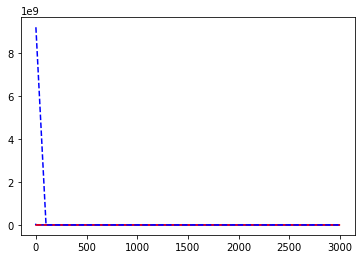

In [5]:
plt.plot(content_loss_history_train[10:], "r")
plt.plot(style_loss_history_train[10:], "b")
plt.plot(*zip(*content_loss_history_val), "r--")
plt.plot(*zip(*style_loss_history_val), "b--")

In [ ]:
image_batch = torch.load("./output/91_9_reconstruction.pt")
image_batch = data.vgg_normalization_undo(image_batch.numpy())
#plt.imshow(transforms.ToPILImage()(image))
image_batch = np.transpose(image_batch, (0, 2, 3, 1))
plt.imshow(image_batch[0])

In [6]:
def show_images(epoch, iteration):
    content_batch = torch.load("./output/{}_{}_content.pt".format(epoch, iteration))
    style_batch = torch.load("./output/{}_{}_style.pt".format(epoch, iteration))
    reconstruction_batch = torch.load("./output/{}_{}_reconstruction.pt".format(epoch, iteration))
    
    content_batch = data.vgg_normalization_undo(content_batch.numpy())
    style_batch = data.vgg_normalization_undo(style_batch.numpy())
    reconstruction_batch = data.vgg_normalization_undo(reconstruction_batch.numpy())
    
    content_batch = np.transpose(content_batch, (0, 2, 3, 1))
    style_batch = np.transpose(style_batch, (0, 2, 3, 1))
    reconstruction_batch = np.transpose(reconstruction_batch, (0, 2, 3, 1))
    
    fig = plt.figure(figsize=(12, 4))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(content_batch[0])
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(style_batch[0])
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(reconstruction_batch[0])

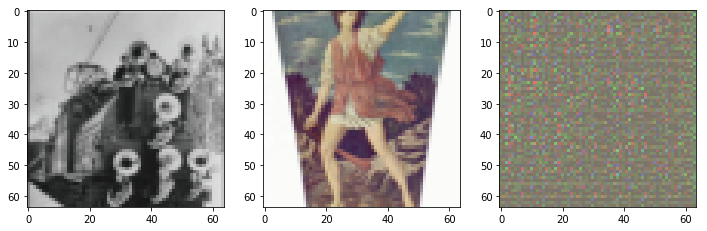

In [11]:
show_images(1, 1)

In [16]:
print(STYLE_DIM)

2310


In [16]:
np.arange(0, 1.05, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])